In [1]:
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0, "../src/")

from post_simulation_utils import (
    plot_regret,
    plot_logloss,
    plot_confidence_interval,
    calc_performance_per_regret,
)

In [2]:
%run ./plot_params.ipynb

In [3]:
# This is the largest possible value of the logloss
log_inf_limit = -np.log(np.finfo("float").eps)
log_inf_limit

36.04365338911715

# Load data

In [4]:
res_paths = [
    osp.join("..", "output", "real_data_bostonHousing_20201126_111146", "results.csv"),
    osp.join("..", "output", "real_data_concrete_20201126_121127", "results.csv"),
    osp.join("..", "output", "real_data_energy_20201126_121136", "results.csv"),
    osp.join("..", "output", "real_data_kin8nm_20201126_121146", "results.csv"),
    osp.join("..", "output", "real_data_naval-propulsion-plant_20201126_141136", "results.csv",),
    osp.join("..", "output", "real_data_power-plant_20201126_151142", "results.csv"),
    osp.join("..", "output", "real_data_protein-tertiary-structure_20201126_201124", "results.csv"),
    osp.join("..", "output", "real_data_wine-quality-red_20201126_081100", "results.csv"),
    osp.join("..", "output", "real_data_yacht_20201126_171104", "results.csv"),
]


res_dfs = [pd.read_csv(res_path) for res_path in res_paths]

In [5]:
# Take the mean over experimetns
res_list = []
for i, res_df in enumerate(res_dfs):
    # Verify each df is for specific dataset
    dataset_name = res_df.dataset_name.unique()[0]
    print(f"{i} {dataset_name}")

    # Filter samples that the pNML was not converged there from empirical reasons
    print(f'Failure: {np.sum(res_df["pnml_success"] == False)}')
    res_df = res_df[res_df["pnml_success"] == True]
    print(
        "Total {}. Inf [regret logloss]=[{} {}]".format(
            len(res_df),
            (res_df["pnml_regret"] >= log_inf_limit).sum(),
            (res_df["pnml_test_logloss"] >= log_inf_limit).sum(),
        )
    )
    res_df = res_df[res_df["pnml_test_logloss"] < log_inf_limit]

    print(f"Features={res_df.num_features.mean()}")
    print(f"Sizes={res_df.trainset_size.unique()}")
    mean_df = res_df.groupby("trainset_size").mean().reset_index()
    std_df = res_df.groupby("trainset_size").agg(np.std, ddof=0).reset_index()
    count_df = res_df.groupby("trainset_size").agg("count")
    res_dict = {
        "dataset_name": dataset_name,
        "mean_df": mean_df,
        "std_df": std_df,
        "count_df": count_df,
        "res_df": res_df.copy(),
    }
    res_list.append(res_dict)
    print()

0 bostonHousing
Failure: 0
Total 23460. Inf [regret logloss]=[0 14]
Features=14.0
Sizes=[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  22  31  45  65
  94 136 196 283 409]

1 concrete
Failure: 0
Total 37080. Inf [regret logloss]=[0 4]
Features=9.0
Sizes=[  2   3   4   5   6   7   8   9  10  16  27  44  71 117 191 312 510 834]

2 energy
Failure: 0
Total 27720. Inf [regret logloss]=[0 0]
Features=9.0
Sizes=[  2   3   4   5   6   7   8   9  10  16  25  40  63  99 157 248 393 621]

3 kin8nm
Failure: 0
Total 294840. Inf [regret logloss]=[0 11]
Features=9.0
Sizes=[   2    3    4    5    6    7    8    9   10   21   42   87  180  370
  761 1566 3223 6635]

4 naval-propulsion-plant
Failure: 0
Total 520000. Inf [regret logloss]=[0 56]
Features=17.0
Sizes=[   2    3    4    5    6    7    8    9   10   11   12   13   14   15
   16   17   18   36   73  146  294  591 1189 2391 4807 9666]

5 power-plant
Failure: 0
Total 267960. Inf [regret logloss]=[0 7]
Features=5.0
Sizes=[   2    3    

# Regret as a point wise confidence

bostonHousing 14


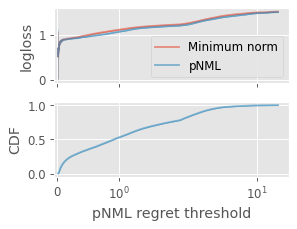

[pNML MN] mean=[1.220 1.247] max=[1.510 1.520] Diff=[0.290 0.272] 
concrete 9


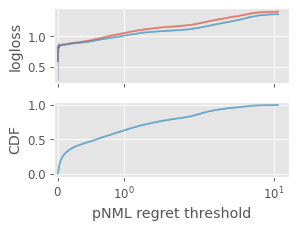

[pNML MN] mean=[1.092 1.156] max=[1.356 1.397] Diff=[0.264 0.241] 
energy 9


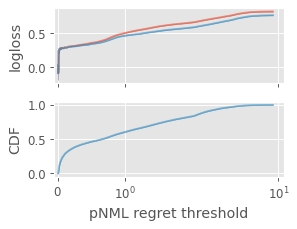

[pNML MN] mean=[0.559 0.632] max=[0.760 0.814] Diff=[0.200 0.182] 
kin8nm 9


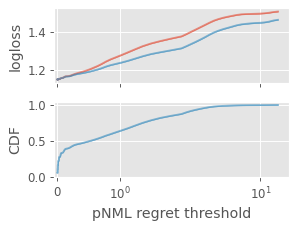

[pNML MN] mean=[1.283 1.339] max=[1.464 1.508] Diff=[0.181 0.169] 
naval-propulsion-plant 17


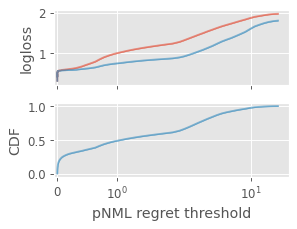

[pNML MN] mean=[1.122 1.537] max=[1.804 1.975] Diff=[0.682 0.439] 
power-plant 5


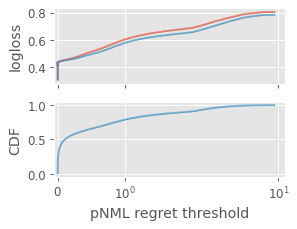

[pNML MN] mean=[0.593 0.618] max=[0.785 0.806] Diff=[0.193 0.188] 
protein-tertiary-structure 10


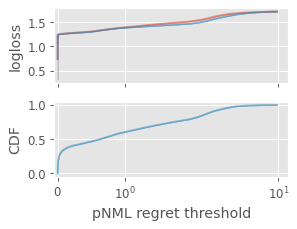

[pNML MN] mean=[1.470 1.517] max=[1.724 1.721] Diff=[0.254 0.204] 
wine-quality-red 12


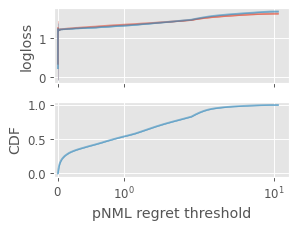

[pNML MN] mean=[1.456 1.450] max=[1.687 1.633] Diff=[0.231 0.183] 
yacht 7


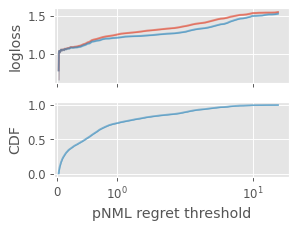

[pNML MN] mean=[1.237 1.294] max=[1.530 1.551] Diff=[0.292 0.256] 


In [6]:
for i, res_dict in enumerate(res_list):
    df = res_dict["res_df"]
    num_features = int(df.num_features.median())
    dataset_name = res_dict["dataset_name"]
    print(dataset_name, num_features)
    (
        regrets,
        counts,
        pnml_means,
        mn_means,
        cdf_means,
        pnml_stds,
        mn_stds,
        cdf_stds,
    ) = calc_performance_per_regret(df)

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(0.6 * w, 0.7 * h))
    ax = axs[0]
    ax.plot(regrets, mn_means, "-", label="Minimum norm", color="C0", alpha=0.6)
    ax.set_xscale("symlog")
    ax.set_xlim(left=-0.05)
    plot_confidence_interval(ax, regrets, mn_means, mn_stds, counts, "C0")

    ax.plot(regrets, pnml_means, label="pNML", color="C1", alpha=0.6)
    plot_confidence_interval(ax, regrets, pnml_means, pnml_stds, counts, "C1")
    ax.set_ylabel("logloss")
    if i == 0:
        ax.legend(loc=4)
    #     ax.set_ylim(bottom=0.0, top=max(pnml_means.max(), mn_means.max()) + 0.1)

    # CDF
    ax = axs[1]
    ax.plot(regrets, cdf_means, color="C1", alpha=0.6)
    plot_confidence_interval(ax, regrets, cdf_means, cdf_stds, counts, "C1")
    ax.set_yticks(np.linspace(0, 1, 3))
    ax.set_xlabel("pNML regret threshold")
    ax.set_ylabel("CDF")

    # Save and show
    plt.tight_layout()
    plt.savefig(f"../output/figures/regret_based_loss_{dataset_name}.pdf")
    plt.show()

    half_idx = np.argmin(np.abs(0.8 - cdf_means))
    pnml_max, mn_max = np.max(pnml_means), np.max(mn_means)
    print(
        "[pNML MN] mean=[{:.3f} {:.3f}] max=[{:.3f} {:.3f}] Diff=[{:.3f} {:.3f}] ".format(
            pnml_means[half_idx],
            mn_means[half_idx],
            pnml_max,
            mn_max,
            pnml_max - pnml_means[half_idx],
            mn_max - mn_means[half_idx],
        )
    )

# Double decent

bostonHousing


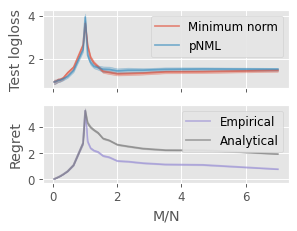

concrete


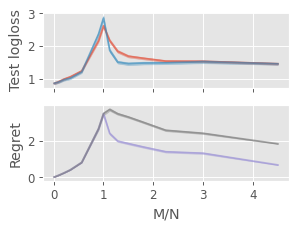

energy


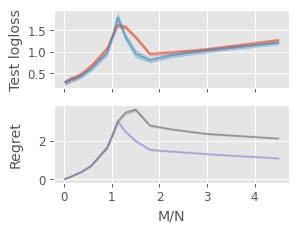

kin8nm


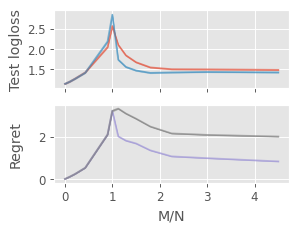

naval-propulsion-plant


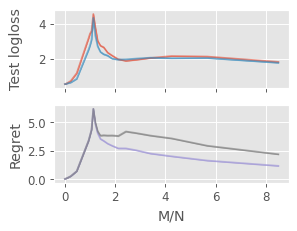

power-plant


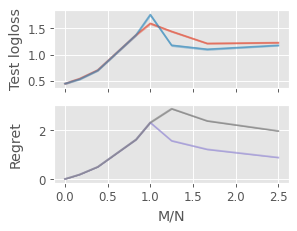

protein-tertiary-structure


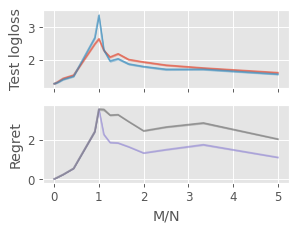

wine-quality-red


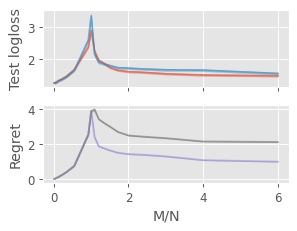

yacht


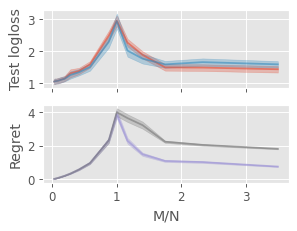

In [7]:
# Plot performance
for i, res_dict in enumerate(res_list):
    dataset_name = res_dict["dataset_name"]
    res_mean_df = res_dict["mean_df"]
    print(dataset_name)

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(0.6 * w, 0.7 * h))
#     axs[0].axvline(
#         res_mean_df["num_features"].mean(),
#         color="black",
#         linewidth=0.5,
#         linestyle="--",
#         marker="",
#         label="M=N",
#     )
#     axs[1].axvline(
#         res_mean_df["num_features"].mean(), color="black", linewidth=0.5, linestyle="--", marker="",
#     )

    ax = axs[0]
    plot_logloss(ax, res_dict, colors=["C0", "C1"])
    if i == 0:
        ax.legend(loc=1)
    ax.set_ylabel("Test logloss")

    ax = axs[1]
    plot_regret(ax, res_dict, colors=["C2", "C3"])

    if i == 0:
        ax.legend(loc=1)
    ax.set_ylabel("Regret")
    ax.set_xlabel("M/N")

#     axs[0].set_xscale("symlog")
    #     axs[0].set_yscale("symlog")
    fig.align_ylabels(axs)
    plt.tight_layout()
    plt.savefig(f"../output/figures/real_data_{dataset_name}.pdf")
    plt.show()